In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
datasets = ['Erasmus14.csv', 'Erasmus15.csv', 'Erasmus16.csv', 'Erasmus17.csv', 'Erasmus18.csv', 'Erasmus19.csv']
#local_dir = r"C:\Users\nicol\OneDrive\Desktop\scuola\NETWORK SCIENCE\progetto\data\\"
local_dir = "data/"

mobility_df = pd.read_csv(local_dir + datasets[0], sep=';',low_memory=False, header=0)
for i in range(1, len(datasets)):
    mobility_df = pd.concat([mobility_df, pd.read_csv(local_dir + datasets[i], sep=';',low_memory=False, header=0)], axis=0)

In [5]:
display(mobility_df)

,Project Reference,Academic Year,Mobility Start Month,Mobility End Month,Mobility Duration,Activity (mob),Field of Education,Participant Nationality,Education Level,Participant Gender,...,Participant Age,Sending Country Code,Sending City,Sending Organization,Sending Organisation Erasmus Code,Receiving Country Code,Receiving City,Receiving Organization,Receiving Organisation Erasmus Code,Participants
0,2014-1-AT01-KA101-000059,2014-2015,2014-07,2014-07,12.0,Staff training abroad,Language acquisition,AT,??? - ? Unknown ?,Female,...,42,AT,Wels,BRG Wels Wallererstraße,-,ES,Malaga,Escuela de Idiomas Nerja,-,1
1,2014-1-AT01-KA101-000059,2014-2015,2014-07,2014-08,7.0,Staff training abroad,Language acquisition,AT,??? - ? Unknown ?,Female,...,25,AT,Wels,BRG Wels Wallererstraße,-,UK,Canterbury,Pilgrims LTD,-,1
2,2014-1-AT01-KA101-000059,2014-2015,2014-07,2014-08,12.0,Staff training abroad,Language acquisition,AT,??? - ? Unknown ?,Female,...,51,AT,Wels,BRG Wels Wallererstraße,-,UK,London,St. Giles International,-,1
3,2014-1-AT01-KA101-000059,2014-2015,2014-08,2014-08,12.0,Staff training abroad,Language acquisition,CZ,??? - ? Unknown ?,Female,...,34,AT,Wels,BRG Wels Wallererstraße,-,UK,London,EF Language Center,-,1
4,2014-1-AT01-KA101-000060,2014-2015,2014-07,2014-07,12.0,Staff training abroad,Teacher training with subject specialization,AT,??? - ? Unknown ?,Female,...,53,AT,Schwarzach,Volksschule Schwarzach,-,IE,Dublin,Centre of English Studies,-,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736429,2019-2-UK01-KA105-062363,2019-2020,2019-09,2019-10,7.0,Mobility of youth workers - Programme Countries,? Unknown ?,TR,??? - ? Unknown ?,Female,...,24,UK,London,YOUTH INNOVATION LTD,-,UK,London,YOUTH INNOVATION LTD,-,1
736430,2019-2-UK01-KA105-062363,2019-2020,2019-09,2019-10,7.0,Mobility of youth workers - Programme Countries,? Unknown ?,UK,??? - ? Unknown ?,Female,...,32,UK,London,YOUTH INNOVATION LTD,-,UK,London,YOUTH INNOVATION LTD,-,1
736431,2019-2-UK01-KA105-062363,2019-2020,2019-09,2019-10,7.0,Mobility of youth workers - Programme Countries,? Unknown ?,UK,??? - ? Unknown ?,Female,...,37,UK,London,YOUTH INNOVATION LTD,-,UK,London,YOUTH INNOVATION LTD,-,1
736432,2019-2-UK01-KA105-062363,2019-2020,2019-09,2019-10,7.0,Mobility of youth workers - Programme Countries,? Unknown ?,UK,??? - ? Unknown ?,Male,...,41,UK,London,YOUTH INNOVATION LTD,-,UK,London,YOUTH INNOVATION LTD,-,1


In [6]:
def filter_data(df):
    df= df[df['Participant Profile']=='Learner']
    df= df[df['Activity (mob)'].str.contains('Student')]
    df = df[~df['Activity (mob)'].str.contains('traineeship')]
    df = df.loc[:, ['Sending Organization', 'Receiving Organization', 'Participants']]
    return df

mobility_df = filter_data(mobility_df)

mobility_df['Sending Organization'] = mobility_df['Sending Organization'].str.upper()
mobility_df['Receiving Organization'] = mobility_df['Receiving Organization'].str.upper()
display(mobility_df)

,Sending Organization,Receiving Organization,Participants
1701,PRIVATE PÄDAGOGISCHE HOCHSCHULE - HOCHSCHULSTI...,ABO AKADEMI,1
1702,PRIVATE PÄDAGOGISCHE HOCHSCHULE - HOCHSCHULSTI...,MALMOE HOEGSKOLA (MALMOE UNIVERSITY),2
1733,IMC FACHHOCHSCHULE KREMS GMBH,HASKOLINN A BIFROST,1
1734,IMC FACHHOCHSCHULE KREMS GMBH,LAUREA-AMMATTIKORKEAKOULU OY,1
1735,IMC FACHHOCHSCHULE KREMS GMBH,METROPOLIA AMMATTIKORKEAKOULU OY,1
...,...,...,...
716937,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1
716938,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,1
716939,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,1
716940,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,3


In [7]:
print('Number of Receiving Universities: ',(mobility_df['Receiving Organization'].nunique()))
print('Number of Sending Universities: ',(mobility_df['Sending Organization'].nunique()))

Number of Receiving Universities:  5220
Number of Sending Universities:  6253


In [8]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, 'Sending Organization']), set(mobility_df.loc[:, 'Receiving Organization']))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
adj_matrix_csc = sparse.csc_matrix((nodes.size, nodes.size),dtype=int)

In [9]:
display(nodes_df)

,Nodes
0,RSE ON REP KARAGANDA STATE TECHNICAL UNIVERSITY
1,UNIVERSIDAD TECNOLÓGICA DE HONDURAS
2,AKADEMIA MUZYCZNA IM. GRAZYNY I KIEJSTUTA BACE...
3,DUALE HOCHSCHULE BADEN-WÜRTTEMBERG MOSBACH
4,TECHNISCHE UNIVERSITAET GRAZ
...,...
7135,SHIBAURA INSTITUTE OF TECHNOLOGY
7136,UGANDA CHRISTIAN UNIVERSITY
7137,VISOKA SKOLA STRUKOVNIH STUDIJA ZA OBRAZOVANJE...
7138,VISOKA TEHNICKA SKOLA STRUKOVNIH STUDIJA SUBOTICA


In [10]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
# ns.visualize_adj(adj_matrix_crs)

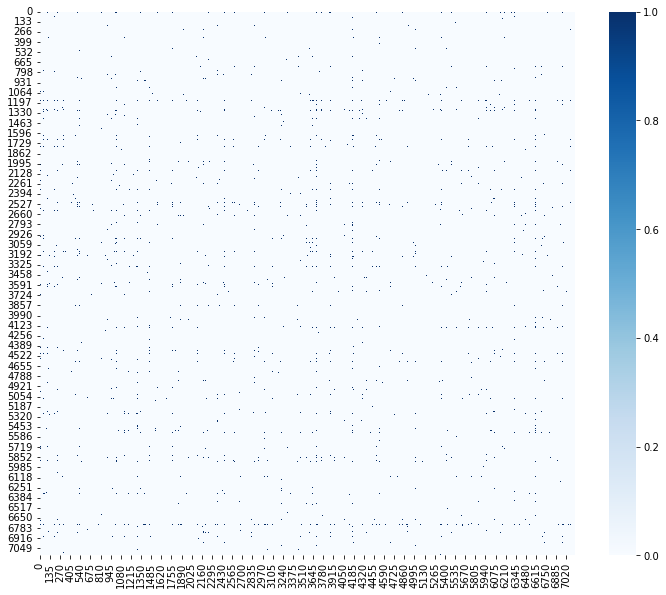

In [11]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = adj_matrix_crs.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

In [12]:
mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)

nodes_component = ns.find_components(adj_matrix_crs, nodes_df)
components_n = nodes_component.groupby(by=["component"]).count()
display(components_n)
for i in range(1, 12):
    print("component ", i )
    nodes_component_i = nodes_component[nodes_component['component'] == i]
    display(nodes_component_i)

,Nodes
component,
0,7113
1,4
2,2
3,2
4,2
5,2
6,2
7,2
8,2


component  1


,Nodes,component
300,IES FUENTE NUEVA,1
991,ASSOCIATION JEANNE PERRIMOND,1
2857,LYCEE SAINT GABRIEL SAINT MICHEL,1
4547,LYCEE PERIER,1


component  2


,Nodes,component
393,SHANGHAI I&C FOREIGN LANGUAGES SCHOOL,2
4896,IES ALFONSO VIII,2


component  3


,Nodes,component
618,MESSIAH COLLEGE,3
1636,SOUTHERN REGIONAL COLLEGE,3


component  4


,Nodes,component
1296,BOSC DE LA COMA,4
1520,LYCÉE SILVIA MONFORT LUISANT,4


component  5


,Nodes,component
1849,LYCEE GENERAL TECHNOLOGIE PIERRE BAYLE,5
4445,INSTITUT MONTSERRAT ROIG,5


component  6


,Nodes,component
2226,FACULTY FOR MEDITERRANEAN BUSINESS STUDIES TIVAT,6
5271,VISOKA SKOLA ZA INSPEKCIJSKI I KADROVSKI MENAD...,6


component  7


,Nodes,component
2509,LEGTA LA GERMINIÈRE,7
3167,CÉGEP DE LA GASPÉSIE ET DES ÎLES,7


component  8


,Nodes,component
2684,NORTHERN VIRGINIA COMMUNITY COLLEGE,8
5854,DUNDEE AND ANGUS COLLEGE,8


component  9


,Nodes,component
3169,BRIDGWATER COLLEGE,9
3854,BRIDGWATER AND TAUNTON COLLEGE,9
7034,EPLEFPA DE SAINT LO THERE,9


component  10


,Nodes,component
3786,CENTRO INTEGRADO DE FORMACIÓN PROFESIONAL JUAN...,10
5902,LYCÉE POLYVALENT GEORGES POMPIDOU,10


component  11


,Nodes,component
4230,INSTITUT PROVENÇANA,11
5804,SOLSKI CENTER KRANJ,11


In [13]:
adj_matrix_crs, mobility_df, nodes_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

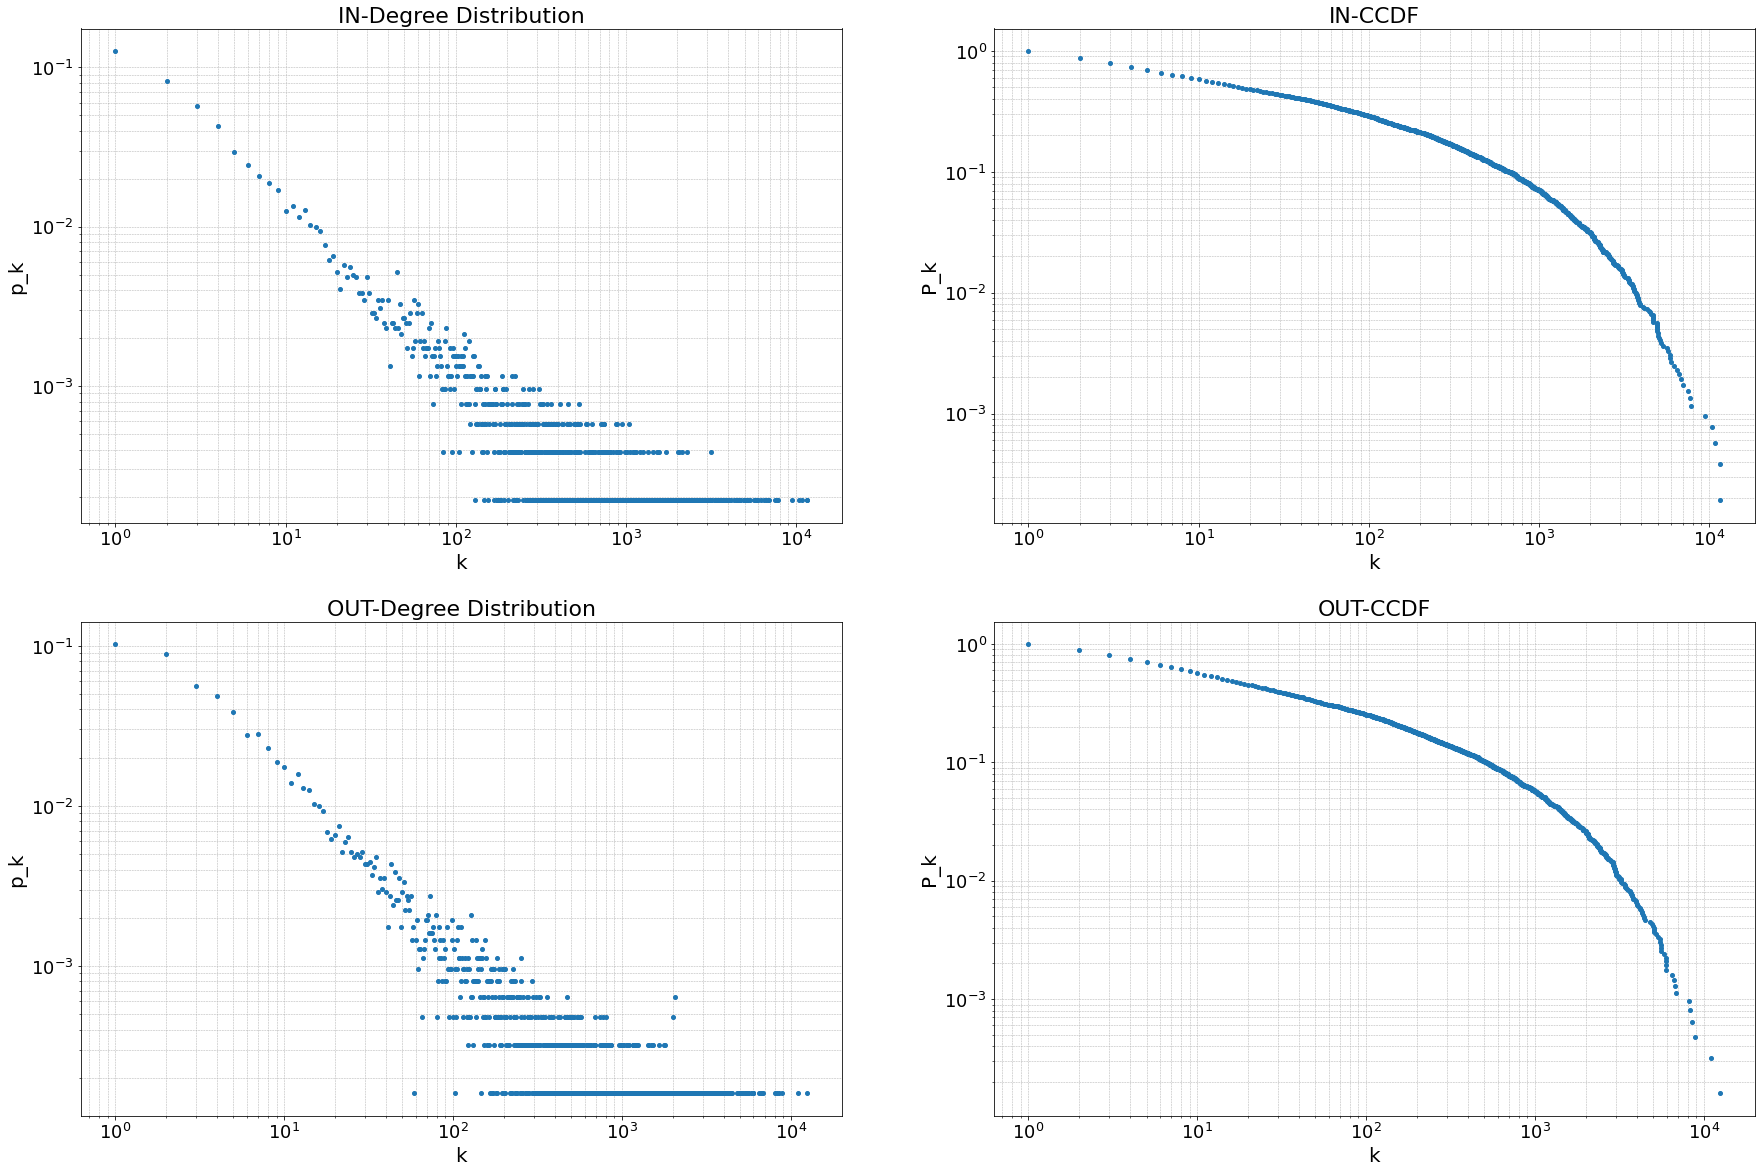

Top 10 for in degree


,Nodes,in degree
2544,UNIVERSITAT DE VALENCIA,11611
3798,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,11540
6710,UNIVERSIDAD DE GRANADA,10809
4357,UNIVERSIDADE DE LISBOA,10424
2988,UNIVERSIDAD COMPLUTENSE DE MADRID,9414
1815,UNIVERSITAT POLITECNICA DE VALENCIA,7854
4107,UNIVERZA V LJUBLJANI,7762
2407,KATHOLIEKE UNIVERSITEIT LEUVEN,7487
6583,UNIVERSIDAD DE SEVILLA,6978
6252,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,6818


Top 10 for out degree


,Nodes,out degree
3798,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,12477
6710,UNIVERSIDAD DE GRANADA,11026
2544,UNIVERSITAT DE VALENCIA,8866
2988,UNIVERSIDAD COMPLUTENSE DE MADRID,8467
2207,UNIVERSITA DEGLI STUDI DI PADOVA,8302
4423,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,8102
2407,KATHOLIEKE UNIVERSITEIT LEUVEN,6867
6538,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,6700
1132,UNIVERSITA DEGLI STUDI DI TORINO,6664
4428,UNIVERSIDAD POLITECNICA DE MADRID,6451


In [14]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### Estimating $\gamma$ 

In [28]:
from collections import Counter
from statistics import mean

d_in = scores['in degree']
d_in = d_in[d_in>0]
d_out = scores['out degree']
d_out = d_out[d_out>0]
kmin = 1500
d2_in = d_in[d_in>kmin]
d2_out = d_out[d_out>kmin]

sorted_d = sorted(d_in)
occurrence = Counter(sorted_d)
x_in = list(occurrence.keys())
y_in = list(occurrence.values())
y_in = y_in/np.sum(y_in)

sorted_d = sorted(d_out)
occurrence = Counter(sorted_d)
x_out = list(occurrence.keys())
y_out = list(occurrence.values())
y_out = y_out/np.sum(y_out)

Pk_in = 1 - np.cumsum(y_in)
Pk_in[-1] = 1 
Pk_in = sorted(Pk_in, reverse = True)
Pk_out = 1 - np.cumsum(y_out)
Pk_out[-1] = 1 
Pk_out = sorted(Pk_out, reverse = True)

In [29]:
ga_in = 1 + 1/mean(np.array(np.log(d2_in/kmin)))
ga_out = 1 + 1/mean(np.array(np.log(d2_out/kmin)))
C_in = (ga_in-1)*kmin**(ga_in-1) # normalization condition
C_out = (ga_out-1)*kmin**(ga_out-1)

pos_in = np.argmax(np.array(x_in)>=kmin)
pos_out = np.argmax(np.array(x_out)>=kmin)

P_kmin_in = Pk_in[pos_in] # constant value that shifts the line where the data are placed
pk_in = C_in*P_kmin_in*x_in**-ga_in
Pk_est_in = C_in*P_kmin_in*x_in**(-(ga_in-1))/(ga_in-1) 

P_kmin_out = Pk_out[pos_out] # constant value that shifts the line where the data are placed
pk_out = C_out*P_kmin_out*x_out**-ga_out
Pk_est_out = C_out*P_kmin_out*x_out**(-(ga_out-1))/(ga_out-1) 

2.7101812650745165 2.713682443865957


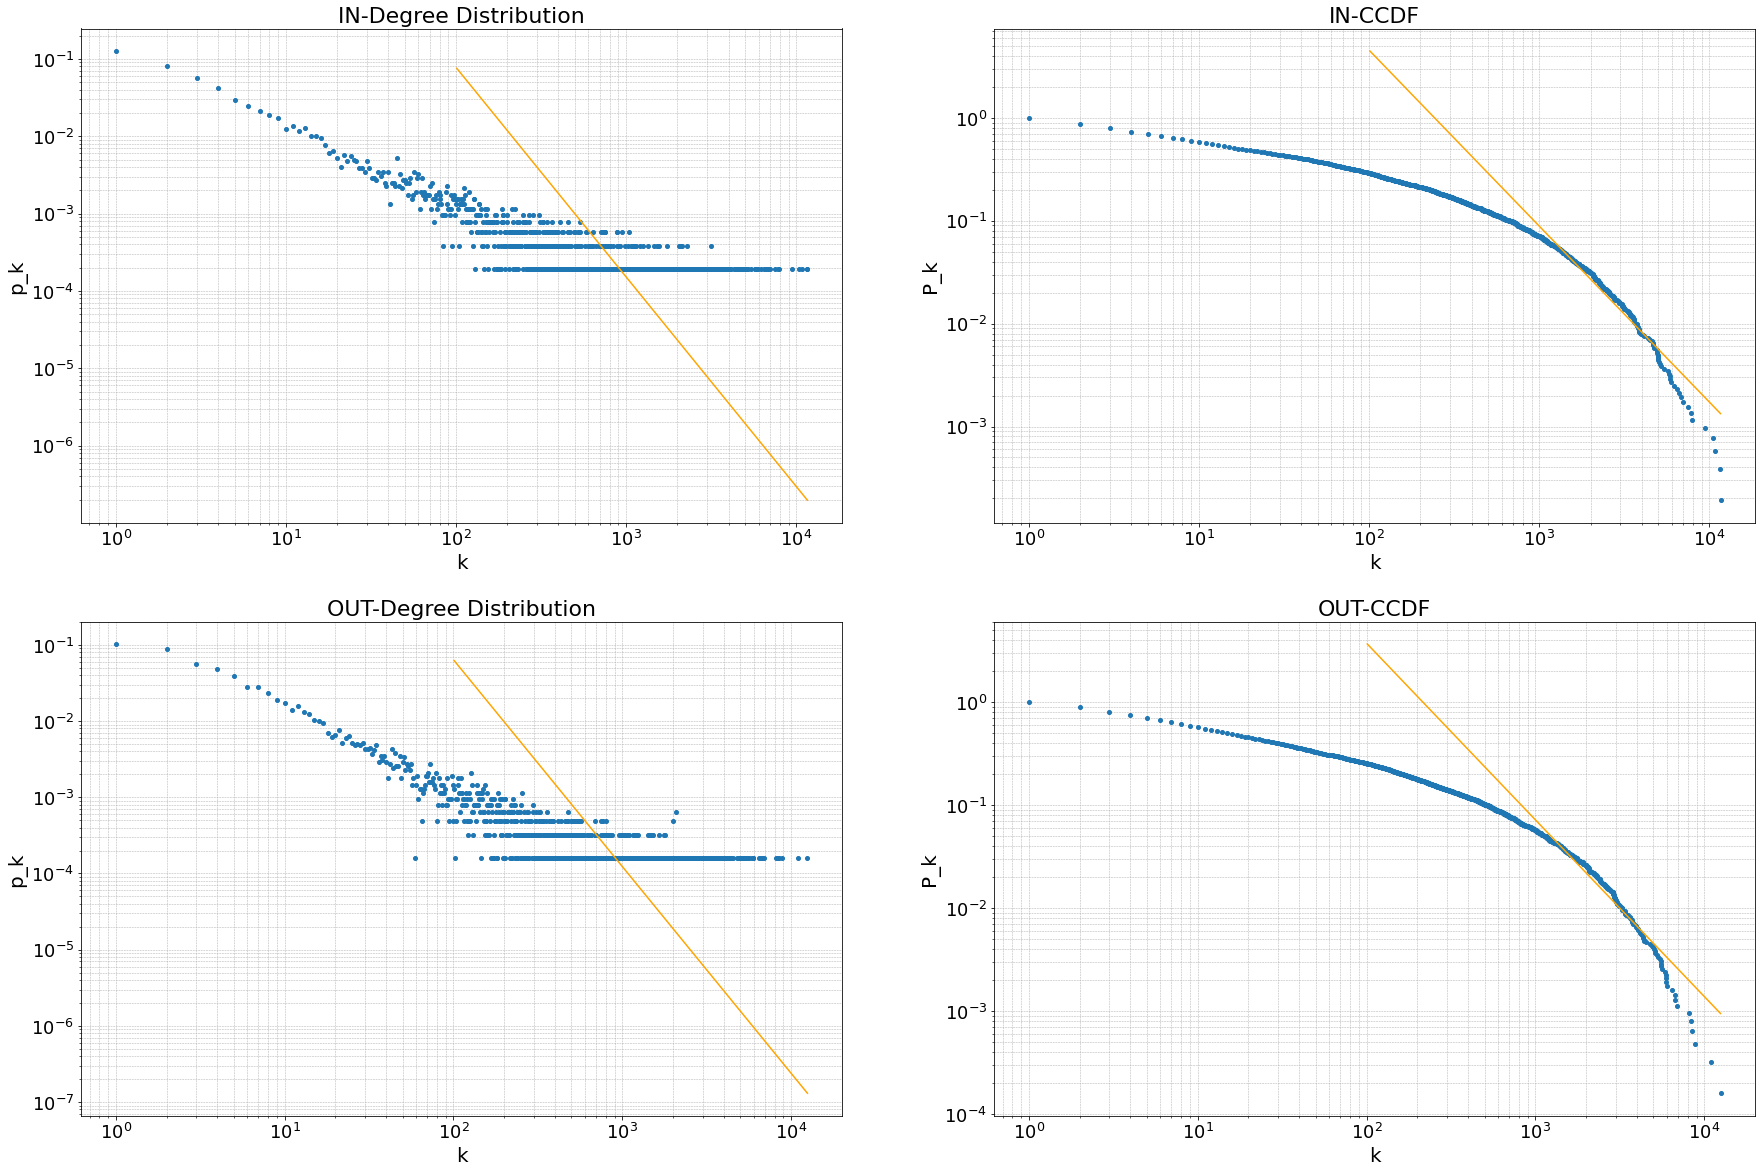

In [30]:
fig, ax = plt.subplots(2, 2, figsize = (30, 20))

def plot_gamma(ax, x, y, title, p, cumulative=False):
    ax.loglog(x, y, 'o', markersize = 4)
    idx = 100 
    ax.loglog(x[100:], p[100:], color='orange')
    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.set_title(title, size = 22)
    ax.set_xlabel("k", size = 20)
    if cumulative:
        ax.set_ylabel("P_k", size = 20)
    else:
        ax.set_ylabel("p_k", size = 20)
    ax.tick_params(labelsize=18)
    ax.tick_params(labelsize=18)

plot_gamma(ax[0,0], x_in, y_in, "IN-Degree Distribution", pk_in)
plot_gamma(ax[0,1], x_in, Pk_in, "IN-CCDF", Pk_est_in, True)
plot_gamma(ax[1,0], x_out, y_out, "OUT-Degree Distribution", pk_out)
plot_gamma(ax[1,1], x_out, Pk_out, "OUT-CCDF", Pk_est_out, True)
print(ga_in, ga_out)
plt.show()

### Estimating $\gamma$ through a linear fit with log binning

In [35]:
# Log binning 
nbins = 20
bins = np.logspace(0, 3.3, nbins)

hist_in = np.histogram(d_in, bins=bins, density=True)
hist_out = np.histogram(d_out, bins=bins, density=True)
logbin_p_k_in = hist_in[0]
logbin_p_k_out = hist_out[0]
middle_bins = np.sqrt( np.delete(bins, 0) * np.delete(bins, nbins-1) )
kmin = 100
mask = np.log10(middle_bins) > np.log10(kmin)
x = np.log10( middle_bins[mask] )
y_in = np.log10( logbin_p_k_in[mask] )
y_out = np.log10( logbin_p_k_out[mask] )

# Linear fit
params_in = np.polyfit(x, y_in, deg =1)
params_out = np.polyfit(x, y_out, deg =1)
lin_gamma_in = -params_in[0]
lin_gamma_out = -params_out[0]

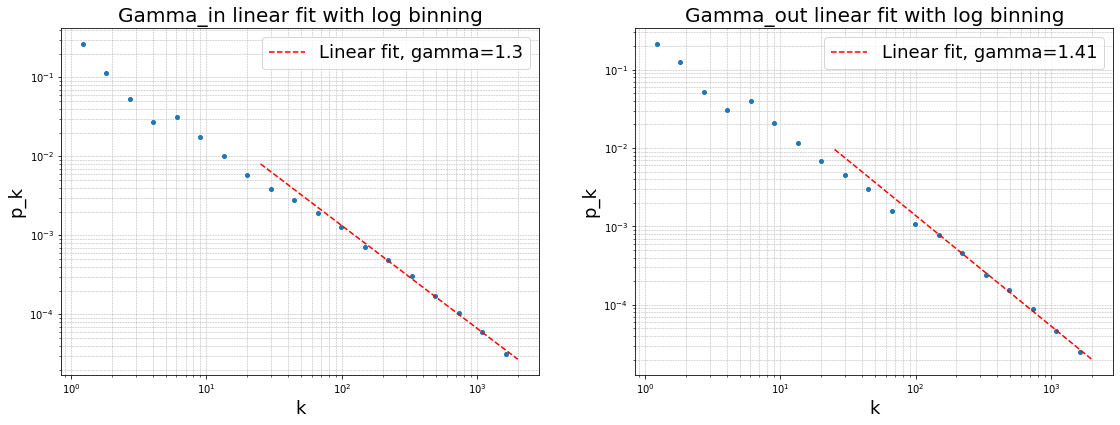

In [36]:
plt.figure(figsize=(60, 60))
plt.subplot(8, 6, 1)
plt.loglog(middle_bins, logbin_p_k_in , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_in linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_in[1])*x2**(-lin_gamma_in) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_in,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.subplot(8, 6, 2)
plt.loglog(middle_bins, logbin_p_k_out , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_out linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_out[1])*x2**(-lin_gamma_out) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_out,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.show()

### HITS (NetworkX)

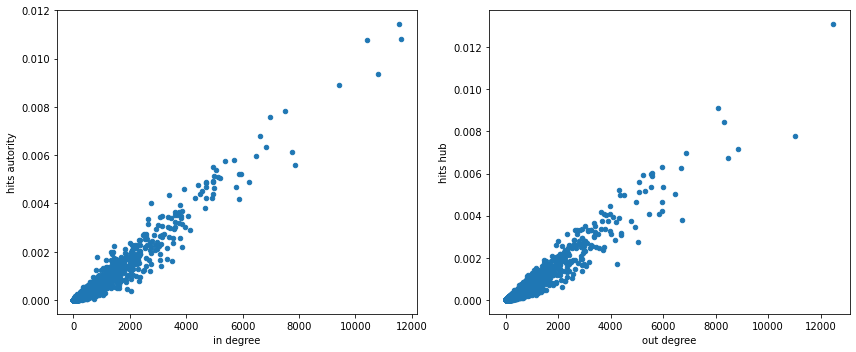

Top 10 for hits hub


,Nodes,hits hub
3972,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.013100
2459,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.009089
5190,UNIVERSITA DEGLI STUDI DI PADOVA,0.008444
3336,UNIVERSIDAD DE GRANADA,0.007785
6096,UNIVERSITAT DE VALENCIA,0.007185
6881,KATHOLIEKE UNIVERSITEIT LEUVEN,0.006954
2997,UNIVERSIDAD COMPLUTENSE DE MADRID,0.006739
3789,UNIVERSIDADE DE LISBOA,0.006314
5374,UNIVERSITA DEGLI STUDI DI TORINO,0.006247
4209,UNIWERSYTET WARSZAWSKI,0.006037


Top 10 for hits autority


,Nodes,hits autority
3972,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.011440
6096,UNIVERSITAT DE VALENCIA,0.010822
3789,UNIVERSIDADE DE LISBOA,0.010794
3336,UNIVERSIDAD DE GRANADA,0.009381
2997,UNIVERSIDAD COMPLUTENSE DE MADRID,0.008920
6881,KATHOLIEKE UNIVERSITEIT LEUVEN,0.007841
1680,UNIVERSIDAD DE SEVILLA,0.007591
5706,UNIVERSITAT DE BARCELONA,0.006804
6099,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.006340
381,UNIVERZA V LJUBLJANI,0.006119


In [17]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

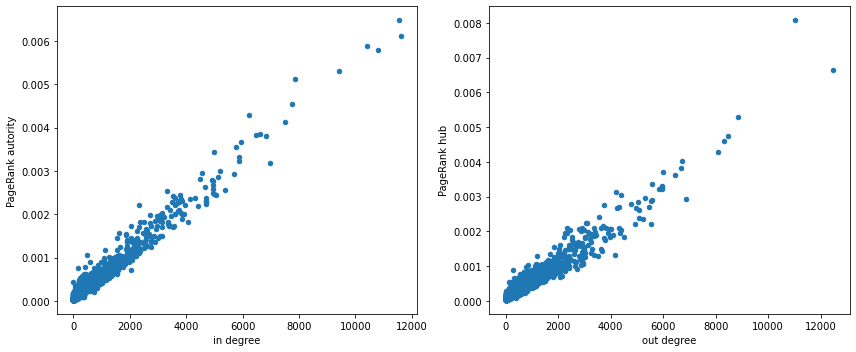

Top 10 for PageRank hub


,Nodes,PageRank hub
3336,UNIVERSIDAD DE GRANADA,0.008073
3972,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006650
6096,UNIVERSITAT DE VALENCIA,0.005288
2997,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004742
5190,UNIVERSITA DEGLI STUDI DI PADOVA,0.004606
2459,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004285
1512,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,0.004039
5374,UNIVERSITA DEGLI STUDI DI TORINO,0.003837
381,UNIVERZA V LJUBLJANI,0.003712
2000,UNIVERSIDAD POLITECNICA DE MADRID,0.003628


Top 10 for PageRank autority


,Nodes,PageRank autority
3972,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006472
6096,UNIVERSITAT DE VALENCIA,0.006109
3789,UNIVERSIDADE DE LISBOA,0.005881
3336,UNIVERSIDAD DE GRANADA,0.005778
2997,UNIVERSIDAD COMPLUTENSE DE MADRID,0.005299
4022,UNIVERSITAT POLITECNICA DE VALENCIA,0.005129
381,UNIVERZA V LJUBLJANI,0.004541
4635,POLITECNICO DI MILANO,0.004299
6881,KATHOLIEKE UNIVERSITEIT LEUVEN,0.004136
5706,UNIVERSITAT DE BARCELONA,0.003863


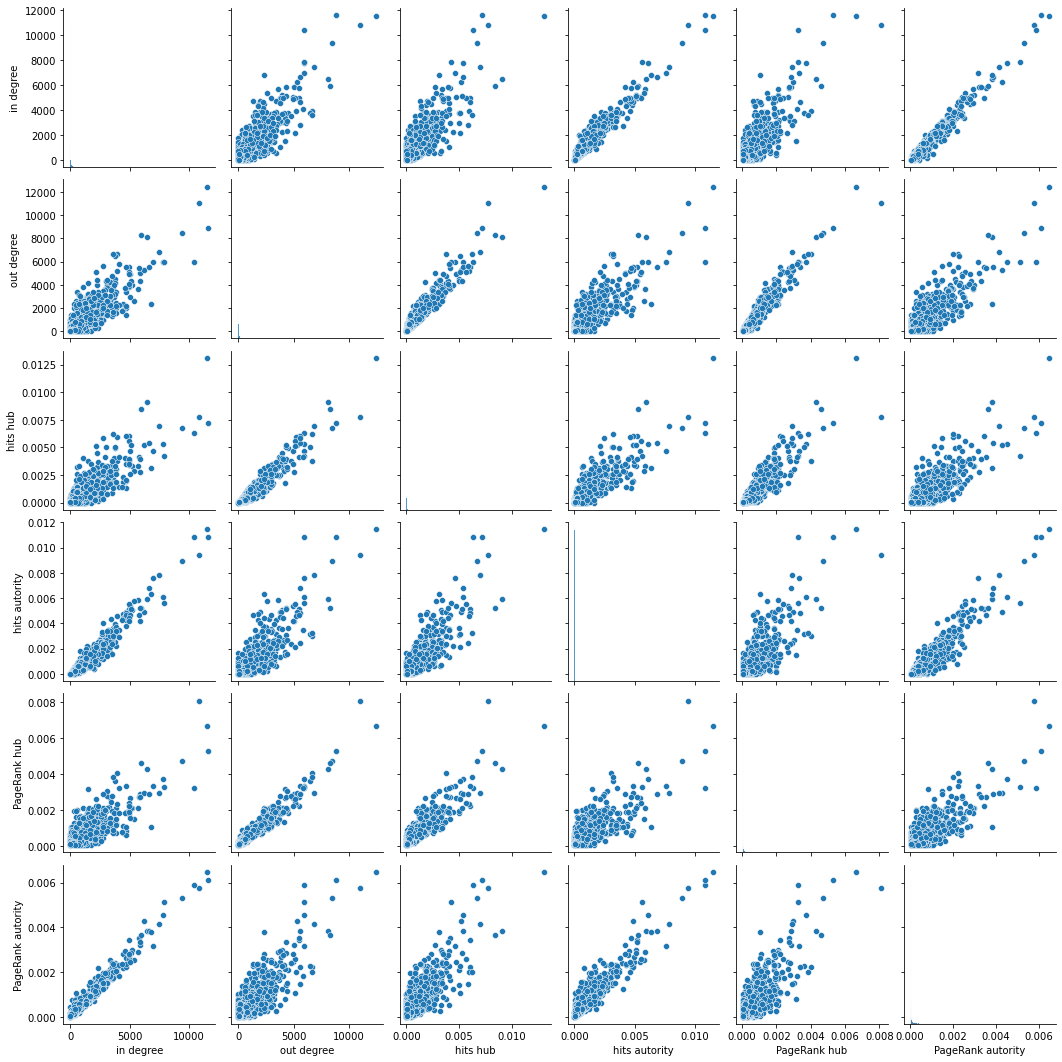

In [18]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
sns.pairplot(scores[['in degree', 'out degree',  'hits hub',
       'hits autority', 'PageRank hub', 'PageRank autority']])
plt.show()
# from IPython.display import Image
# Image('pairplot_score.png',)

### Assortativity

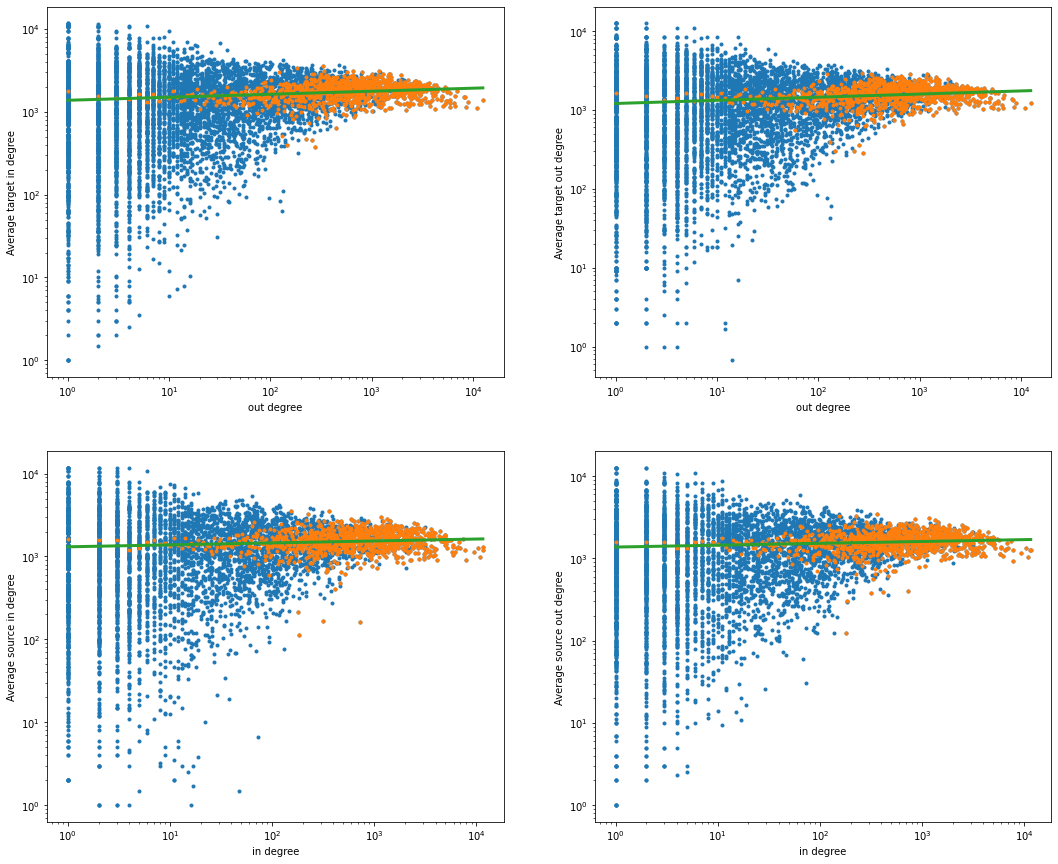

(0.03640225809134687,
 0.03978585272547555,
 0.023439716362907606,
 0.022567719259201067)

In [19]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

### Robustness

In [20]:
#attack: removing hubs first
nodes_byhub = scores.sort_values('PageRank hub', ascending=False)['NodeID']
indices = list(nodes_byhub)
uni_df = mobility_df.copy()
GC_frac_a = [1]
for node in indices:
    uni_df = uni_df.loc[(uni_df['sourceID'] != node) & (uni_df['targetID'] != node)]
    temp_serie = uni_df.groupby(['sourceID', 'targetID']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    GC_frac_a.append(ns.fraction_in_giant(temp_adj))


In [21]:
#random node removal
import random
#10 by 10, with average over 10 trials each time
intervals = list(range(10, len(nodes_byhub+1), 10))
uni_df = mobility_df.copy()
GC_frac_r = [1]
for i in intervals:
    i_GC_frac = []
    for j in range(10):
        removed = random.sample(indices, i)
        temp_df = uni_df.loc[~(uni_df['sourceID'].isin(removed) | (uni_df['targetID'].isin(removed)))]
        temp_serie = temp_df.groupby(['sourceID', 'targetID']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
        i_GC_frac.append(ns.fraction_in_giant(temp_adj))
    GC_frac_r.append(sum(i_GC_frac)/10)

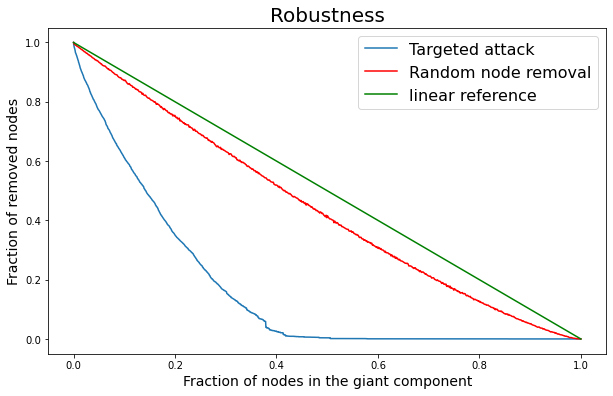

In [22]:
fig = plt.figure(figsize=(10,6))
plt.plot([i/len(nodes_byhub) for i in range(len(nodes_byhub)+1)], GC_frac_a, label='Targeted attack')
plt.plot([0]+[i/(len(intervals)*10) for i in intervals], GC_frac_r, 'r', label='Random node removal')
plt.plot([0,1], [1,0], 'g', label='linear reference')
plt.xlabel('Fraction of nodes in the giant component', size=14)
plt.ylabel('Fraction of removed nodes', size=14)
plt.title('Robustness', size=20)
plt.legend(fontsize=16)
plt.show()